# In this notebook, the following things are done for BRCA
* [Univarite CoxPH model for seleting significant features](#CoxPH)
* [Clustering for generating the gorups](#Clustering(Using-k-means-clustering-and-plot-it-based-PCA-features))
* [KM Plot generation and calculate logrank p-value](#KM-Plot-Generation-for-each-cluster-using-KaplanMeier-Filter)

In [1]:
import os
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np

In [2]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score

In [3]:
from lifelines import CoxPHFitter 
import xenaPython as xena
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test, multivariate_logrank_test

/home/pdutta/anaconda3/envs/dgcca/lib/python3.7/site-packages/xenaPython/__init__.py:110: FutureWarning: Possible nested set at position 7
  re.sub(r"^[^[]+[[]([^]]*)[]].*$", r"\1", query, flags=re.DOTALL))


In [4]:
from chart_studio import plotly
import plotly.graph_objs as go
from plotly import tools
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sb

In [28]:
FOLDER_PATH = "/home/pdutta/Github/Multiview_clustering_DGCCA/results/final_embedding/LUSC/views=3_numEpochs=100__val_batch_size=32__train_batch_size=32__arch=[[1000,500],[900,400],[200,150]]__lr=0.0000001__latDim=100"
# read_dictionary = np.load(PARAM_DETAILS_PATH,allow_pickle='TRUE').item()
# # print(read_dictionary['hello']) # displays "world"
# CANCER = read_dictionary['cancer_type']
# DATA_PATH = "/home/pdutta/Data/DGCCA/"
# RESULT_PATH= "/home/pdutta/Github/Multiview_clustering_DGCCA/results/"
# UNI_COX_MODEL_PATH = RESULT_PATH + 'UniCoX_embedding/{}/'.format(CANCER)
for path, subdirs, files in os.walk(FOLDER_PATH):
    for subdir in subdirs:
        sub_dir_path = os.path.join(path, subdir)
        for file in os.listdir(sub_dir_path):
            if file.endswith('.npy'):
                read_dictionary = np.load(os.path.join(sub_dir_path, file),allow_pickle='TRUE').item()
            elif file.endswith('.csv'):
                df_embedding = pd.read_csv(os.path.join(sub_dir_path, file))
        CANCER = read_dictionary['cancer_type']
        UNI_COX_MODEL_PATH = '../results/UniCoX_embedding/{}/{}/{}'.format(CANCER, read_dictionary['base_name'], subdir)
        if not os.path.exists(UNI_COX_MODEL_PATH):
            os.makedirs(UNI_COX_MODEL_PATH)
        id_mapping = pd.read_csv('/home/pdutta/Data/DGCCA/TCGA_{}/methyl_rnaseq_mirna_minmax_idmapping.tsv'.format(CANCER), sep='\t')
        df_embedding.index = id_mapping['sample']

### Get the final embedding which is obtained from DGCCA

In [47]:
df_embedding = pd.read_csv(read_dictionary['csv_path'])
df_embedding.index = id_mapping['sample']

In [48]:
df_embedding

,DGCCA_1,DGCCA_2,DGCCA_3,DGCCA_4,DGCCA_5,DGCCA_6,DGCCA_7,DGCCA_8,DGCCA_9,DGCCA_10,...,DGCCA_91,DGCCA_92,DGCCA_93,DGCCA_94,DGCCA_95,DGCCA_96,DGCCA_97,DGCCA_98,DGCCA_99,DGCCA_100
sample,,,,,,,,,,,,,,,,,,,,,
TCGA-3C-AAAU-01,-0.016367,-0.036150,0.049150,0.008032,0.068431,-0.011093,-0.054180,-0.024666,-0.033242,0.012672,...,-0.009186,-0.009890,0.005163,0.014104,0.002118,-0.038252,-0.025944,-0.017853,0.046688,0.054172
TCGA-3C-AALI-01,-0.019236,-0.043427,-0.034489,0.016974,0.006472,-0.057904,-0.027968,0.006370,0.039873,0.034665,...,-0.048955,-0.046716,-0.010221,0.007200,0.018808,-0.029995,-0.052296,-0.013707,0.015356,-0.066219
TCGA-3C-AALJ-01,0.012737,0.068866,0.016279,0.010855,-0.002104,-0.006970,-0.039833,0.058468,0.009587,0.017052,...,-0.023631,-0.080923,-0.011030,-0.018717,0.019225,0.016382,-0.043153,0.000378,-0.001393,-0.027403
TCGA-3C-AALK-01,-0.003611,0.007354,-0.015623,-0.005434,-0.022942,0.002298,0.037716,0.019699,0.033159,-0.009358,...,0.035899,0.024832,0.012127,0.001385,0.009605,-0.032591,0.037982,0.024680,-0.010268,0.032607
TCGA-4H-AAAK-01,-0.005001,-0.024092,-0.026904,0.063146,-0.018029,-0.008761,-0.016874,-0.022647,0.012239,0.001104,...,-0.003336,-0.016152,-0.013049,0.000136,0.010076,0.008735,0.024196,0.003491,-0.005233,-0.016985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-WT-AB44-01,0.118957,-0.014666,-0.011379,-0.019745,0.026456,-0.038498,0.026611,-0.083431,0.015256,-0.011011,...,-0.067409,0.026131,-0.013089,-0.000537,-0.007607,0.055207,-0.044779,0.037422,0.008509,0.007763
TCGA-XX-A899-01,0.001134,-0.004384,-0.019452,-0.015850,0.008998,-0.007255,-0.015307,0.015522,-0.000438,0.020207,...,-0.014971,-0.051338,-0.009821,0.017609,-0.019593,0.007566,0.048160,-0.033787,-0.016155,0.011878
TCGA-XX-A89A-01,-0.032159,0.029808,0.024255,-0.030886,-0.001763,-0.008745,-0.061949,0.008635,0.067930,0.036661,...,-0.008448,-0.005890,0.027936,0.004040,0.049680,0.045992,0.000263,-0.014578,-0.040489,0.021402


### Get the survival file and generate the dataframe

In [49]:
host = xena.PUBLIC_HUBS['tcgaHub']
dataset = 'survival/{}_survival.txt'.format(CANCER)

In [50]:
samples = xena.dataset_samples (host, dataset, None)
features = xena.dataset_field(host, dataset)
features

['DFI',
 'DFI.time',
 'DSS',
 'DSS.time',
 'OS',
 'OS.time',
 'PFI',
 'PFI.time',
 'Redaction',
 '_PATIENT',
 'sampleID']

In [51]:
[position, [status,time]] = xena.dataset_probe_values(host, dataset, samples, ['OS','OS.time'])
df_status = pd.DataFrame(list(zip(samples, time, status)), columns = ['sample','time', 'status'])
df_status = df_status.set_index('sample')
df_status.to_csv("clinical.csv")

In [52]:
df_status

,time,status
sample,,
TCGA-3C-AAAU-01,4047,0
TCGA-3C-AALI-01,4005,0
TCGA-3C-AALJ-01,1474,0
TCGA-3C-AALK-01,1448,0
TCGA-4H-AAAK-01,348,0
...,...,...
TCGA-WT-AB44-01,883,0
TCGA-XX-A899-01,467,0
TCGA-XX-A89A-01,488,0


In [79]:
df_status = df_status[df_status['time'] !=0]
df_status

,time,status
sample,,
TCGA-3C-AAAU-01,4047,0
TCGA-3C-AALI-01,4005,0
TCGA-3C-AALJ-01,1474,0
TCGA-3C-AALK-01,1448,0
TCGA-4H-AAAK-01,348,0
...,...,...
TCGA-WT-AB44-01,883,0
TCGA-XX-A899-01,467,0
TCGA-XX-A89A-01,488,0


In [80]:
print(df_status.shape, df_embedding.shape)
df_merge = pd.merge(df_embedding, df_status, on='sample')
print(df_merge.head())
print(df_merge.shape)
print(df_merge.groupby(['status']).size())

(1223, 2) (1233, 100)
                  DGCCA_1   DGCCA_2   DGCCA_3   DGCCA_4   DGCCA_5   DGCCA_6  \
sample                                                                        
TCGA-3C-AAAU-01 -0.016367 -0.036150  0.049150  0.008032  0.068431 -0.011093   
TCGA-3C-AALI-01 -0.019236 -0.043427 -0.034489  0.016974  0.006472 -0.057904   
TCGA-3C-AALJ-01  0.012737  0.068866  0.016279  0.010855 -0.002104 -0.006970   
TCGA-3C-AALK-01 -0.003611  0.007354 -0.015623 -0.005434 -0.022942  0.002298   
TCGA-4H-AAAK-01 -0.005001 -0.024092 -0.026904  0.063146 -0.018029 -0.008761   

                  DGCCA_7   DGCCA_8   DGCCA_9  DGCCA_10  ...  DGCCA_93  \
sample                                                   ...             
TCGA-3C-AAAU-01 -0.054180 -0.024666 -0.033242  0.012672  ...  0.005163   
TCGA-3C-AALI-01 -0.027968  0.006370  0.039873  0.034665  ... -0.010221   
TCGA-3C-AALJ-01 -0.039833  0.058468  0.009587  0.017052  ... -0.011030   
TCGA-3C-AALK-01  0.037716  0.019699  0.033159 -0.00935

In [81]:
print(set(df_status.index.values).difference(set(df_embedding.index.values)))
print(set(df_embedding.index.values).difference(set(df_status.index.values)))
print(set(df_embedding.index.values) ^ (set(df_status.index.values)))

{'TCGA-BH-A0BO-11', 'TCGA-E2-A14Y-11', 'TCGA-E2-A15L-11', 'TCGA-BH-A18F-11', 'TCGA-BH-A0BL-11', 'TCGA-BH-A0DE-11'}
{'TCGA-A8-A083-01', 'TCGA-E2-A1IP-01', 'TCGA-A8-A081-01', 'TCGA-A8-A09Z-01', 'TCGA-C8-A12T-01', 'TCGA-BH-A0B2-11', 'TCGA-C8-A12K-01', 'TCGA-A8-A06N-01', 'TCGA-A8-A09G-01', 'TCGA-A8-A094-01', 'TCGA-A8-A096-01', 'TCGA-A8-A08H-01', 'TCGA-PL-A8LV-01', 'TCGA-BH-A0B2-01', 'TCGA-A8-A090-01', 'TCGA-C8-A133-01'}
{'TCGA-PL-A8LV-01', 'TCGA-A8-A096-01', 'TCGA-A8-A06N-01', 'TCGA-A8-A083-01', 'TCGA-C8-A12T-01', 'TCGA-A8-A081-01', 'TCGA-BH-A18F-11', 'TCGA-A8-A090-01', 'TCGA-A8-A09G-01', 'TCGA-C8-A133-01', 'TCGA-E2-A1IP-01', 'TCGA-BH-A0B2-01', 'TCGA-A8-A09Z-01', 'TCGA-BH-A0BL-11', 'TCGA-A8-A08H-01', 'TCGA-BH-A0B2-11', 'TCGA-A8-A094-01', 'TCGA-BH-A0BO-11', 'TCGA-E2-A15L-11', 'TCGA-BH-A0DE-11', 'TCGA-C8-A12K-01', 'TCGA-E2-A14Y-11'}


<a id='CoxPH'></a>
### Univariate CoxPH model

In [82]:
df_merge = df_merge.replace('NaN', np.nan)
df_merge = df_merge.dropna()
df_merge

,DGCCA_1,DGCCA_2,DGCCA_3,DGCCA_4,DGCCA_5,DGCCA_6,DGCCA_7,DGCCA_8,DGCCA_9,DGCCA_10,...,DGCCA_93,DGCCA_94,DGCCA_95,DGCCA_96,DGCCA_97,DGCCA_98,DGCCA_99,DGCCA_100,time,status
sample,,,,,,,,,,,,,,,,,,,,,
TCGA-3C-AAAU-01,-0.016367,-0.036150,0.049150,0.008032,0.068431,-0.011093,-0.054180,-0.024666,-0.033242,0.012672,...,0.005163,0.014104,0.002118,-0.038252,-0.025944,-0.017853,0.046688,0.054172,4047.0,0
TCGA-3C-AALI-01,-0.019236,-0.043427,-0.034489,0.016974,0.006472,-0.057904,-0.027968,0.006370,0.039873,0.034665,...,-0.010221,0.007200,0.018808,-0.029995,-0.052296,-0.013707,0.015356,-0.066219,4005.0,0
TCGA-3C-AALJ-01,0.012737,0.068866,0.016279,0.010855,-0.002104,-0.006970,-0.039833,0.058468,0.009587,0.017052,...,-0.011030,-0.018717,0.019225,0.016382,-0.043153,0.000378,-0.001393,-0.027403,1474.0,0
TCGA-3C-AALK-01,-0.003611,0.007354,-0.015623,-0.005434,-0.022942,0.002298,0.037716,0.019699,0.033159,-0.009358,...,0.012127,0.001385,0.009605,-0.032591,0.037982,0.024680,-0.010268,0.032607,1448.0,0
TCGA-4H-AAAK-01,-0.005001,-0.024092,-0.026904,0.063146,-0.018029,-0.008761,-0.016874,-0.022647,0.012239,0.001104,...,-0.013049,0.000136,0.010076,0.008735,0.024196,0.003491,-0.005233,-0.016985,348.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-WT-AB44-01,0.118957,-0.014666,-0.011379,-0.019745,0.026456,-0.038498,0.026611,-0.083431,0.015256,-0.011011,...,-0.013089,-0.000537,-0.007607,0.055207,-0.044779,0.037422,0.008509,0.007763,883.0,0
TCGA-XX-A899-01,0.001134,-0.004384,-0.019452,-0.015850,0.008998,-0.007255,-0.015307,0.015522,-0.000438,0.020207,...,-0.009821,0.017609,-0.019593,0.007566,0.048160,-0.033787,-0.016155,0.011878,467.0,0
TCGA-XX-A89A-01,-0.032159,0.029808,0.024255,-0.030886,-0.001763,-0.008745,-0.061949,0.008635,0.067930,0.036661,...,0.027936,0.004040,0.049680,0.045992,0.000263,-0.014578,-0.040489,0.021402,488.0,0


In [83]:
df_uni_cox_result= pd.DataFrame(columns=['feature_name', 'coefficient', 'coef_lower_95%','coef_upper_95%','z-value','p-value','-log2(p)','partial_AIC','C-index'])
temp = 0
for i in df_merge.columns[:-2]:
    data_r= df_merge.loc[:,[i,'time', 'status']]
    cph = CoxPHFitter()   
    cph.fit(data_r, 'time', event_col='status') 
    df_uni_cox_result.loc[temp, ['feature_name']] = i
    df_uni_cox_result.loc[temp, ['coefficient']] = cph.summary.loc[i]['coef']
    df_uni_cox_result.loc[temp, ['coef_lower_95%']] = cph.summary.loc[i]['coef lower 95%']
    df_uni_cox_result.loc[temp, ['coef_upper_95%']] = cph.summary.loc[i]['coef upper 95%']
    df_uni_cox_result.loc[temp, ['z-value']] = cph.summary.loc[i]['z']
    df_uni_cox_result.loc[temp, ['p-value']] = cph.summary.loc[i]['p']
    df_uni_cox_result.loc[temp, ['-log2(p)']] = cph.summary.loc[i]['-log2(p)']
    df_uni_cox_result.loc[temp, ['partial_AIC']] = cph.AIC_partial_
    df_uni_cox_result.loc[temp, ['C-index']] = cph.concordance_index_
    temp=temp +1

In [84]:
df_uni_cox_result

,feature_name,coefficient,coef_lower_95%,coef_upper_95%,z-value,p-value,-log2(p),partial_AIC,C-index
0,DGCCA_1,0.155297,-3.258019,3.568614,0.089173,0.928944,0.106336,2336.863647,0.511137
1,DGCCA_2,0.862646,-2.878642,4.603933,0.451918,0.651328,0.618543,2336.667314,0.525568
2,DGCCA_3,1.105041,-2.358065,4.568148,0.625404,0.531706,0.9113,2336.475599,0.508574
3,DGCCA_4,0.042315,-3.344772,3.429402,0.024486,0.980465,0.028462,2336.870983,0.471175
4,DGCCA_5,1.344439,-2.189239,4.878117,0.745697,0.455851,1.133367,2336.313106,0.494434
...,...,...,...,...,...,...,...,...,...
95,DGCCA_96,-0.029926,-3.413232,3.353381,-0.017336,0.986169,0.020094,2336.871288,0.4763
96,DGCCA_97,1.405797,-2.074841,4.886434,0.791611,0.428588,1.222338,2336.241123,0.508128
97,DGCCA_98,-0.186937,-3.39014,3.016266,-0.114382,0.908935,0.137751,2336.858484,0.472565
98,DGCCA_99,1.707583,-1.909035,5.324201,0.925395,0.35476,1.495083,2336.018294,0.504943


In [85]:
df_uni_cox_result.to_csv(UNI_COX_MODEL_PATH+"UniVaR_CoXPh_result.csv", index=False)

In [86]:
df_sig_feature = df_uni_cox_result.loc[(df_uni_cox_result['p-value'] < 0.05)].reset_index(drop=True)
df_sig_feature

,feature_name,coefficient,coef_lower_95%,coef_upper_95%,z-value,p-value,-log2(p),partial_AIC,C-index
0,DGCCA_28,-3.700633,-7.176047,-0.22522,-2.086977,0.03689,4.760619,2332.629855,0.532861
1,DGCCA_69,-4.200777,-7.926957,-0.474597,-2.209601,0.027133,5.203816,2331.910893,0.539957


In [87]:
important_features = list(df_sig_feature['feature_name'])
all_column_values = important_features + ['time','status']
df_survival = df_merge[all_column_values]
df_clustering = df_merge[important_features]

In [88]:
df_survival

,DGCCA_28,DGCCA_69,time,status
sample,,,,
TCGA-3C-AAAU-01,0.028250,0.007221,4047.0,0
TCGA-3C-AALI-01,0.024288,0.017862,4005.0,0
TCGA-3C-AALJ-01,0.014334,-0.015963,1474.0,0
TCGA-3C-AALK-01,0.005937,0.011715,1448.0,0
TCGA-4H-AAAK-01,-0.016939,0.120327,348.0,0
...,...,...,...,...
TCGA-WT-AB44-01,0.021711,-0.029377,883.0,0
TCGA-XX-A899-01,0.027301,0.001237,467.0,0
TCGA-XX-A89A-01,0.045403,0.008678,488.0,0


In [89]:
df_clustering.to_csv(UNI_COX_MODEL_PATH+"UniVaR_cluster_feature.csv")

In [90]:
df_survival.to_csv(UNI_COX_MODEL_PATH+"UniVaR_survival_feature.csv")

## Clustering(Using k-means clustering and plot it based PCA features)

In [91]:
pca = PCA(n_components=2)
embedding_pca = pca.fit_transform(df_clustering)
#print(embedding_pca)
df_clustering['PCA_1'] = embedding_pca[:,0]
df_clustering['PCA_2'] = embedding_pca[:,1]
df_clustering

,DGCCA_28,DGCCA_69,PCA_1,PCA_2
sample,,,,
TCGA-3C-AAAU-01,0.028250,0.007221,-0.001694,-0.029576
TCGA-3C-AALI-01,0.024288,0.017862,-0.012786,-0.027145
TCGA-3C-AALJ-01,0.014334,-0.015963,0.019311,-0.012550
TCGA-3C-AALK-01,0.005937,0.011715,-0.009271,-0.008114
TCGA-4H-AAAK-01,-0.016939,0.120327,-0.120016,-0.000682
...,...,...,...,...
TCGA-WT-AB44-01,0.021711,-0.029377,0.033626,-0.017973
TCGA-XX-A899-01,0.027301,0.001237,0.004098,-0.027799
TCGA-XX-A89A-01,0.045403,0.008678,-0.000734,-0.046765


In [92]:
df_clustering.iloc[:,-2]

sample
TCGA-3C-AAAU-01   -0.001694
TCGA-3C-AALI-01   -0.012786
TCGA-3C-AALJ-01    0.019311
TCGA-3C-AALK-01   -0.009271
TCGA-4H-AAAK-01   -0.120016
                     ...   
TCGA-WT-AB44-01    0.033626
TCGA-XX-A899-01    0.004098
TCGA-XX-A89A-01   -0.000734
TCGA-Z7-A8R5-01   -0.045021
TCGA-Z7-A8R6-01    0.001267
Name: PCA_1, Length: 1216, dtype: float64

In [93]:
clustering_data = df_clustering.iloc[:,:-2]
clustering_data

,DGCCA_28,DGCCA_69
sample,,
TCGA-3C-AAAU-01,0.028250,0.007221
TCGA-3C-AALI-01,0.024288,0.017862
TCGA-3C-AALJ-01,0.014334,-0.015963
TCGA-3C-AALK-01,0.005937,0.011715
TCGA-4H-AAAK-01,-0.016939,0.120327
...,...,...
TCGA-WT-AB44-01,0.021711,-0.029377
TCGA-XX-A899-01,0.027301,0.001237
TCGA-XX-A89A-01,0.045403,0.008678


k = 2, silhouette width = 0.27458557754749313, calinski-harabasz score = 457.0320300040612
k = 3, silhouette width = 0.29365902671373245, calinski-harabasz score = 509.4400319656552
k = 4, silhouette width = 0.30779428645237217, calinski-harabasz score = 498.93674296476723
k = 5, silhouette width = 0.322997455580167, calinski-harabasz score = 532.362727252204
k = 6, silhouette width = 0.3135614978965514, calinski-harabasz score = 516.4573691453419
k = 7, silhouette width = 0.31957292006151083, calinski-harabasz score = 522.4117056772535
k = 8, silhouette width = 0.31744708034542285, calinski-harabasz score = 518.6602792138997
k = 9, silhouette width = 0.32113005986671544, calinski-harabasz score = 528.0040901449477


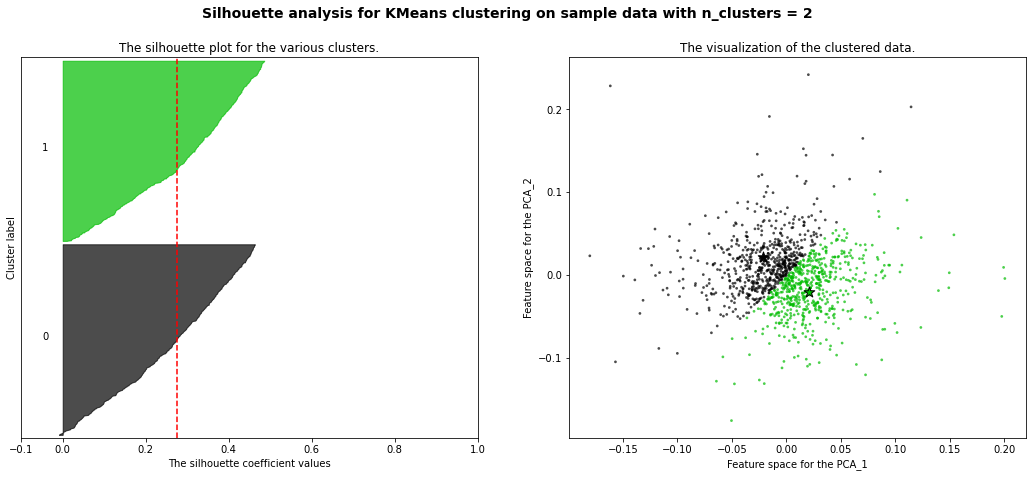

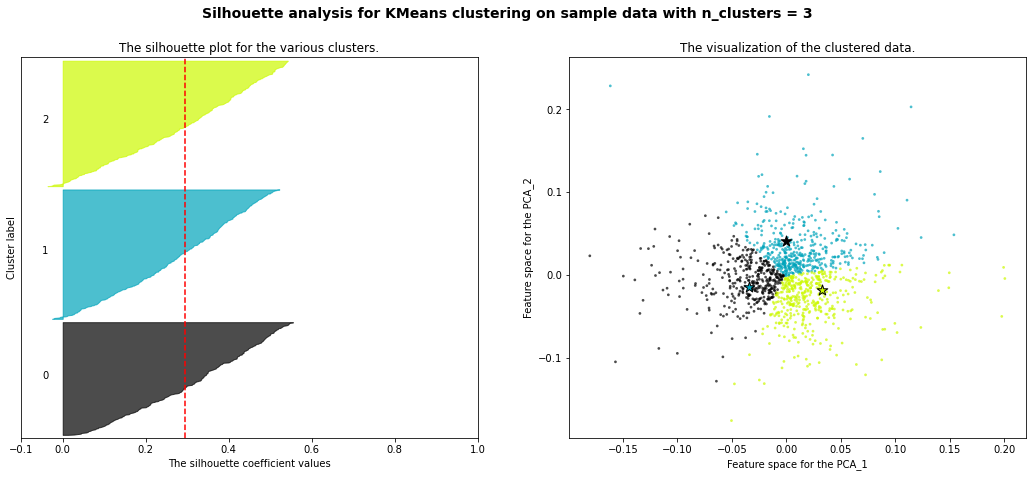

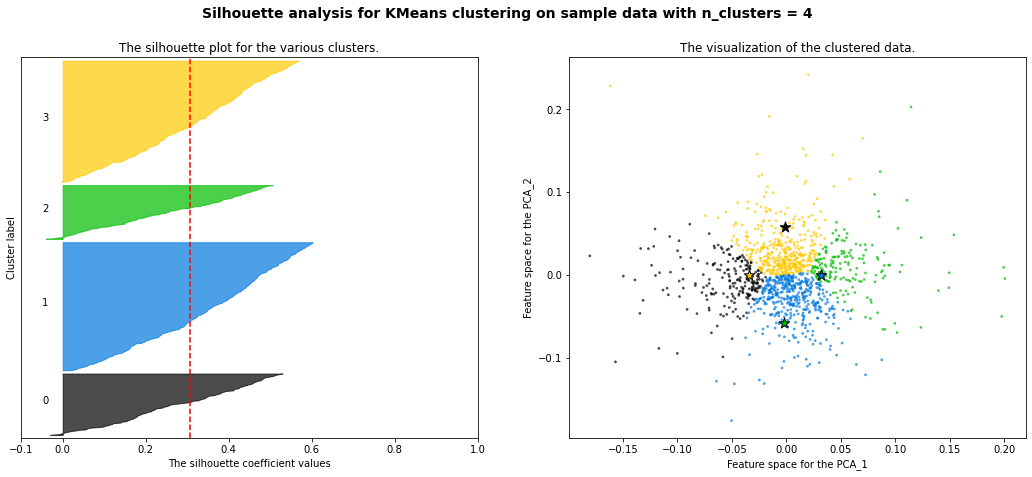

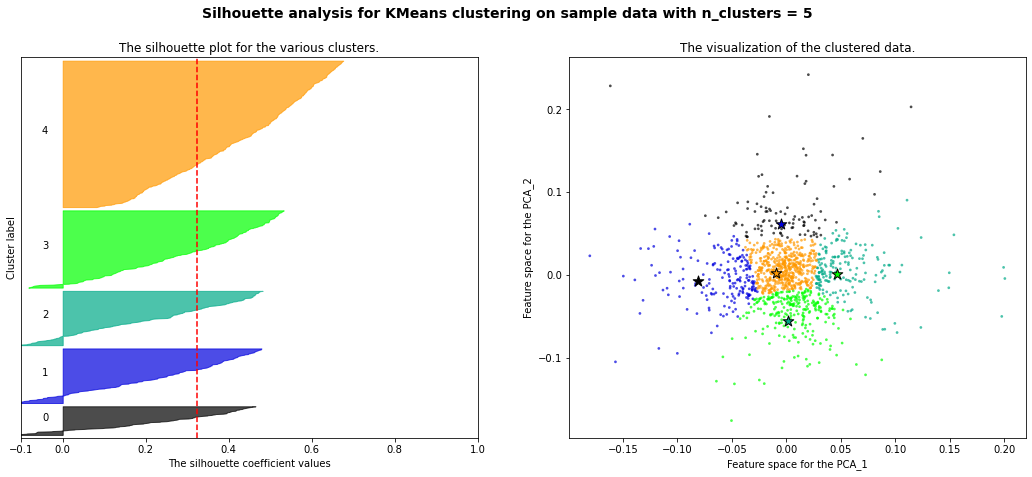

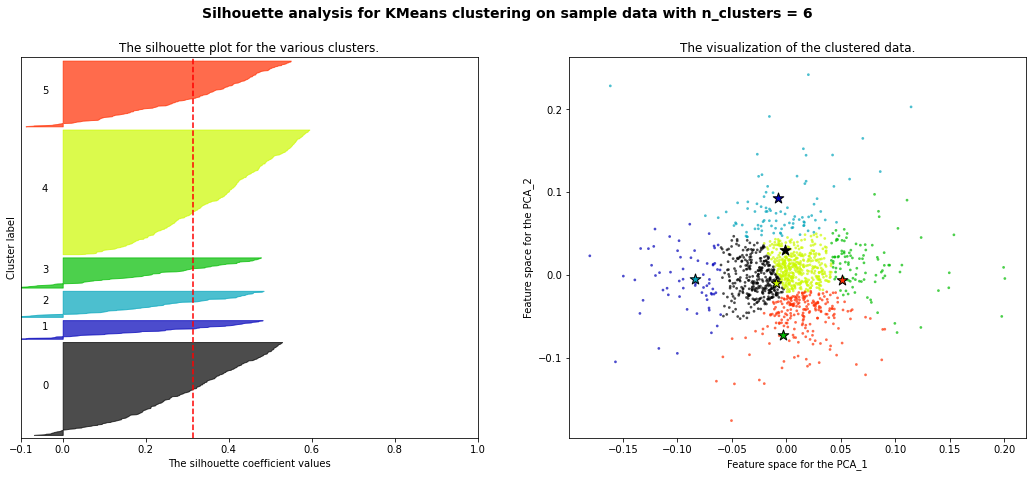

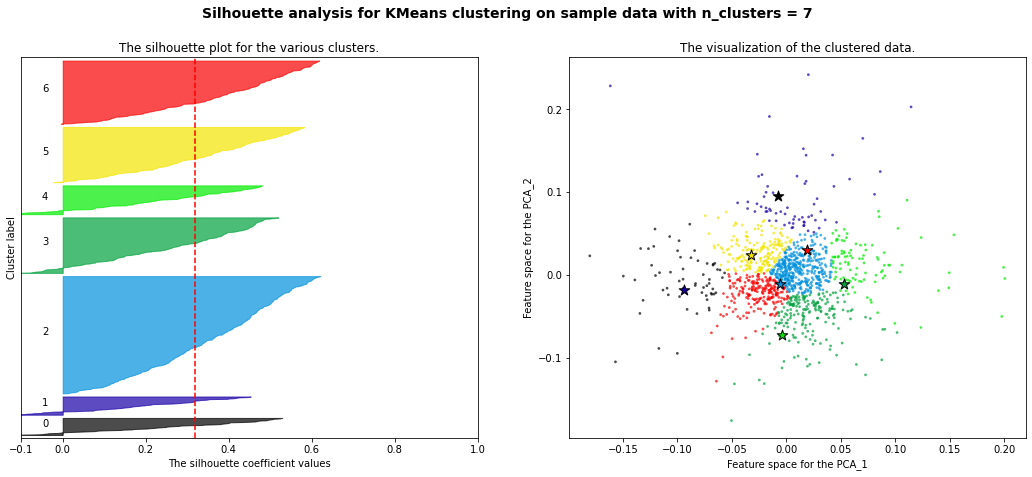

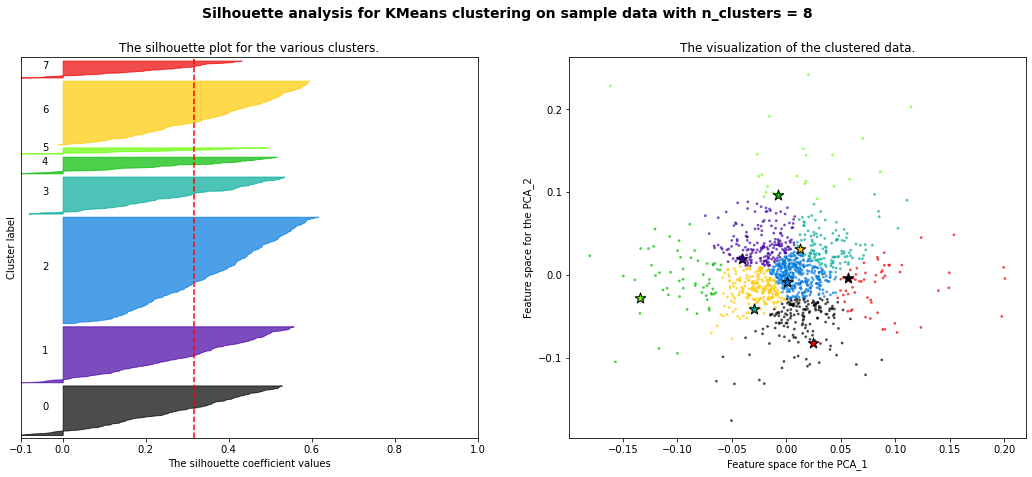

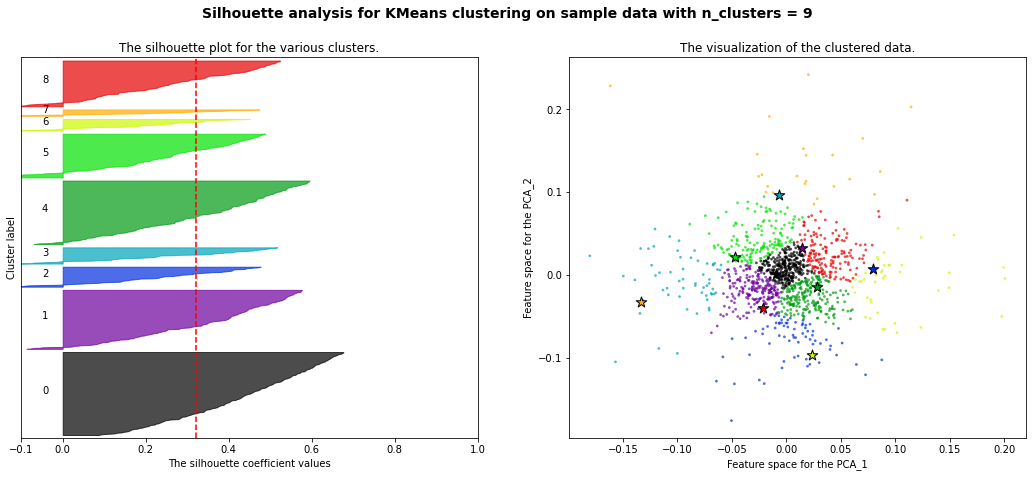

In [94]:
for k in range(2,10):
    kmeans = KMeans(n_clusters=k,n_init=100,max_iter=2000,random_state=123)
    kmeans.fit(clustering_data)
    centroids = kmeans.cluster_centers_
    labels = kmeans.labels_
    sil_score = metrics.silhouette_score(clustering_data, labels)
    ch_score = metrics.calinski_harabasz_score(clustering_data, labels)
    print('k = {}, silhouette width = {}, calinski-harabasz score = {}'.format(k,sil_score,ch_score))
    df_survival['DGCCA_cluster_'+str(k)] = labels
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    

    # The 1st subplot is the silhouette plot, The silhouette coefficient can range from -1, 1 but in this example all lie within [-0.1, 1], /
    # The (n_clusters+1)*10 is for inserting blank space between silhouette plots of individual clusters, to demarcate them clearly.
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(clustering_data) + (k + 1) * 10])



    # Compute the silhouette scores for each sample
    sample_silhouette_values = metrics.silhouette_samples(clustering_data, labels)
    
    y_lower = 10
    color_list = []
    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k)
        color_list.append(color)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=sil_score, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    
    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(labels.astype(float) / k)
    ax2.scatter(df_clustering.iloc[:,-2], df_clustering.iloc[:,-1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')
    for i in range(len(centroids)):
        ax2.scatter(centroids[i][0], centroids[i][1], color = color_list[i], edgecolor='black',s = 124, marker='*' )
    #plot.show()

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the PCA_1")
    ax2.set_ylabel("Feature space for the PCA_2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % k),
                 fontsize=14, fontweight='bold')

## KM Plot Generation for each cluster using KaplanMeier Filter

In [99]:
df_cluster_assignment = df_survival.iloc[:,-10:].reset_index()
df_cluster_assignment.index +=1
df_cluster_assignment.to_csv("cluster_assignment_new.csv")

In [98]:
df_survival.iloc[:,-10:].reset_index()

,sample,time,status,DGCCA_cluster_2,DGCCA_cluster_3,DGCCA_cluster_4,DGCCA_cluster_5,DGCCA_cluster_6,DGCCA_cluster_7,DGCCA_cluster_8,DGCCA_cluster_9
0,TCGA-3C-AAAU-01,4047.0,0,1,2,1,3,5,6,6,4
1,TCGA-3C-AALI-01,4005.0,0,1,0,1,3,0,6,6,1
2,TCGA-3C-AALJ-01,1474.0,0,1,2,1,4,4,2,2,4
3,TCGA-3C-AALK-01,1448.0,0,0,0,1,4,0,6,2,0
4,TCGA-4H-AAAK-01,348.0,0,0,0,0,1,1,0,4,3
...,...,...,...,...,...,...,...,...,...,...,...
1211,TCGA-WT-AB44-01,883.0,0,1,2,1,2,4,2,2,4
1212,TCGA-XX-A899-01,467.0,0,1,2,1,3,5,3,2,4
1213,TCGA-XX-A89A-01,488.0,0,1,2,1,3,5,3,0,4
1214,TCGA-Z7-A8R5-01,3287.0,0,0,0,3,1,0,5,1,5


In [100]:
kmf = KaplanMeierFitter()

In [101]:
df_kmf = df_survival.iloc[:,-10:]
df_kmf

,time,status,DGCCA_cluster_2,DGCCA_cluster_3,DGCCA_cluster_4,DGCCA_cluster_5,DGCCA_cluster_6,DGCCA_cluster_7,DGCCA_cluster_8,DGCCA_cluster_9
sample,,,,,,,,,,
TCGA-3C-AAAU-01,4047.0,0,1,2,1,3,5,6,6,4
TCGA-3C-AALI-01,4005.0,0,1,0,1,3,0,6,6,1
TCGA-3C-AALJ-01,1474.0,0,1,2,1,4,4,2,2,4
TCGA-3C-AALK-01,1448.0,0,0,0,1,4,0,6,2,0
TCGA-4H-AAAK-01,348.0,0,0,0,0,1,1,0,4,3
...,...,...,...,...,...,...,...,...,...,...
TCGA-WT-AB44-01,883.0,0,1,2,1,2,4,2,2,4
TCGA-XX-A899-01,467.0,0,1,2,1,3,5,3,2,4
TCGA-XX-A89A-01,488.0,0,1,2,1,3,5,3,0,4


In [102]:
T = df_kmf["time"]
E = df_kmf["status"]

2 0.5541763566153772
3 0.11026043011948033
4 0.008908060548686177
5 0.00031186133530178674
6 0.0054461684679556685
7 0.12761015365000924
8 0.11151681997525499
9 0.004133296638689077


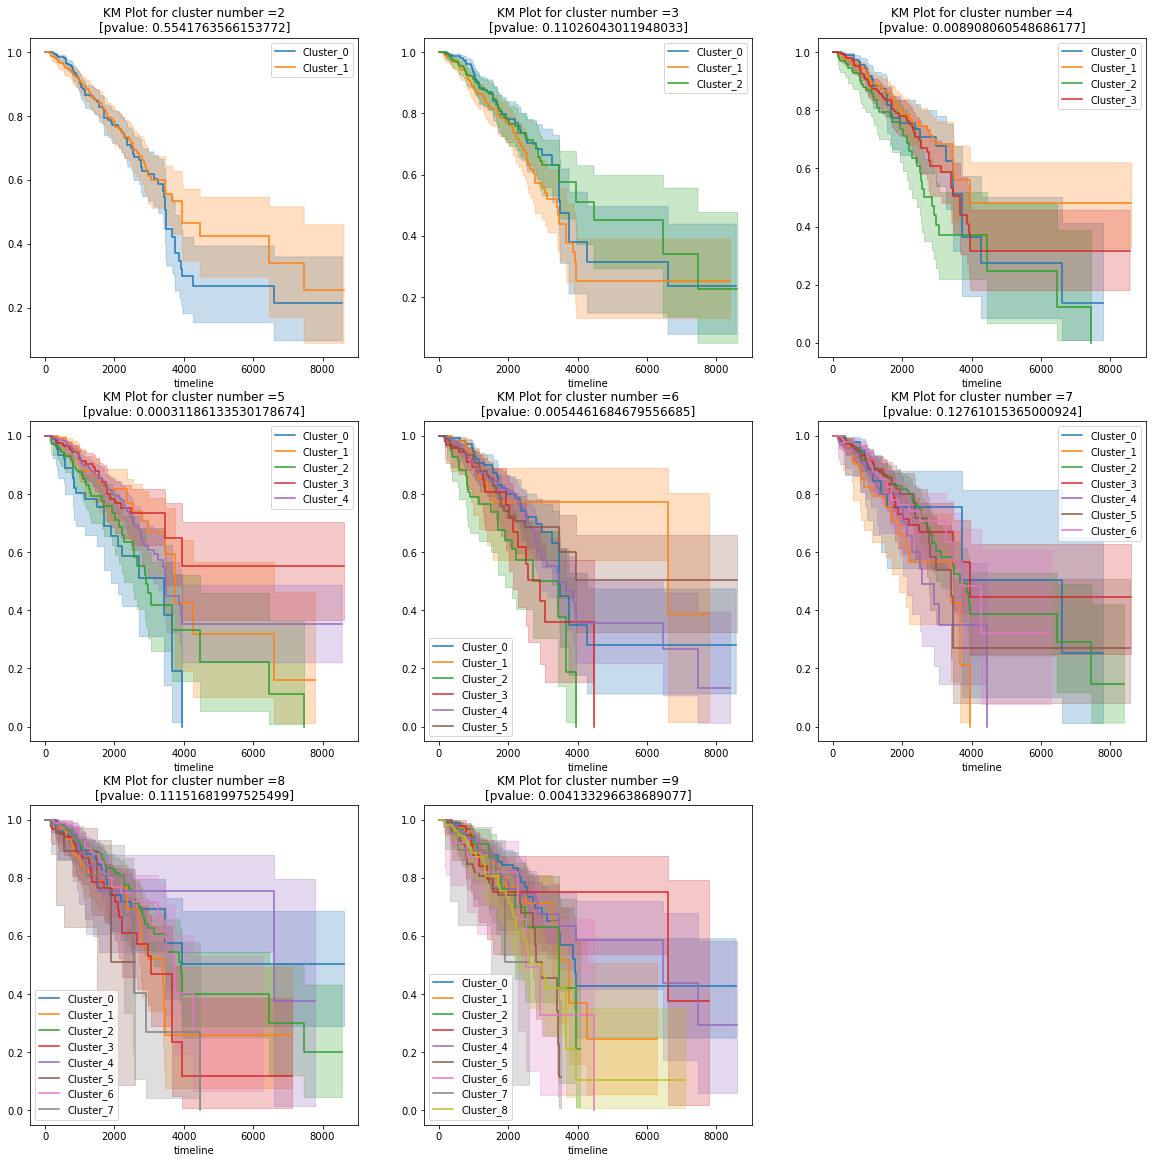

In [103]:
plt.figure(figsize=(20,20))
cluster_number = 2
for k in range(2,10):
    ax = plt.subplot(3, 3, k - 1)
    
    for i in range(k):
        #t = np.linspace(0, 50, 51)
        col_name = 'DGCCA_cluster_'+str(k)
        T = df_kmf[df_kmf[col_name]==i]['time'].to_list()
        E = df_kmf[df_kmf[col_name]==i]['status'].to_list()
        kmf.fit(T, E, label="Cluster_"+str(i))
        ax = kmf.plot_survival_function(ax=ax)
    result = multivariate_logrank_test(df_kmf['time'], df_kmf[col_name], df_kmf['status'])
    #print("##",result.test_statistic)
    print(k,result.p_value)
    #print("IO",result.print_summary())
    plt.title("KM Plot for cluster number ="+str(k)+"\n[pvalue: {}]".format(result.p_value));